In [270]:
#ALl imports needed for the whole script
from bs4 import BeautifulSoup
import requests
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pmdarima import auto_arima #This one has to be installed using pip



In [272]:
def Ingestion():
    # My baseurl for collecting new cases each day/30 days 
    base_url = 'https://www.nicd.ac.za/latest-confirmed-cases-of-covid-19-in-south-africa-{}/'
    
    #starting on the 2 of August 2021 while the Virus was still peaking and the website's structure at this time was a plus
    start_date = datetime(2021, 8, 2)
    num_days = 30
    
    #generating links for each day since the only thing changing on the url is the date
    # example url='https://www.nicd.ac.za/latest-confirmed-cases-of-covid-19-in-south-africa-11-August-2021/'
    urls = [base_url.format((start_date + timedelta(days=i)).strftime('%d-%B-%Y').lstrip('0')) for i in range(num_days)]
    
    #for my daily cases
    data= []
    
    #this is the fun :( part of the ingestion:web scraping
    #Iterating through each day and only taking the daily cases
    #This affects the time complexity of my code very much(i tried optimising)
    for url in urls:
        #standard Procedure :)
        response = requests.get(url)
        soup = BeautifulSoup(response.text,'html')
        
        #The filtering begins here
        table= soup.find_all('table')[1]
        titles =table.find_all('tr')[0]
        headings = [title.text.strip() for title in titles if title.text.strip()]
        heading = [headings[0],headings[4]]
        df = pd.DataFrame(columns=heading)
        column_data = table.find_all('tr')
        
        for row in column_data[1:]:
            row_data = row.find_all('td')
            single = [row_data[0].text.strip(), row_data[4].text.strip()]
            length = len(df)
            df.loc[length] = single

        total_value = df.loc[df['Province'] == 'Total', heading[1]].values
        total = float(total_value[0].replace(',', '').replace(' ', '')) if total_value else None
        data.append(total)   
    return data


In [274]:
#Just to See the daily case and how i fetched the data
#data = Ingestion()
#print(data)

In [275]:
def Modeling(data):
    # Convert the data into a pandas DataFrame
    df = pd.DataFrame({'date': pd.date_range(datetime(2021, 8, 2), periods=len(data), freq='D'), 'new_cases': data})
    
    #TO find the best parameters for my model
    '''step= auto_arima(df['new_cases'],trace=True,supress_warnings=True)
    step.summary()'''


    #alwasy told to split my data in training,testing and validation data
    '''train=df.iloc[:-10]
    #test=df.iloc[-10:]
    #print(train.shape,test.shape)
    model = ARIMA(train['new_cases'], order=(2, 0, 0 ))
    model = model.fit()
    model.summary()'''

    #This is where I train and predict using my model
    model = ARIMA(df['new_cases'],order=(2,0,0))
    model=model.fit()
    last=df.tail()
    #print(last)
    future_dates= pd.date_range(start="2021-09-01",end="2021-09-07")
    pred= model.predict(start=len(df),end=len(df)+6,type="levels").rename('ARIMA Predictions')
    pred.index =future_dates
    return pred

In [276]:
#just to see the seven forecasted data points
#results=Modeling(data)
#print(results)

In [279]:
def SimpleReporting(pred):
    # The forecasted results to a .csv file
    #This will be saved on the current working directory
    pred.reset_index().to_csv('covid_forecast_results.csv', index=False, header=['date', 'new_cases'])

    # Plotingt the forecast as a time series
    plt.figure(figsize=(10, 6))
    plt.plot(pred.index, pred.values, label='Forecasted Cases', color='red')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.title('COVID-19 Forecast for South Africa')
    plt.legend()

    # Saveing the plot as a .png file
    plt.savefig('covid_forecast_plot.png')
    plt.show()

    #advice about future improvements
    #With this advice i am still in the recent past and not the present
    with open('improvement_advice.txt', 'w') as file:
        file.write("In order to enhance forecast accuracy, the institute could consider incorporating additional data sources beyond the current daily COVID-19 cases. Integration of factors such as population density, vaccination rates, mobility trends, and socioeconomic indicators could provide valuable insights. Including these variables in the forecasting model may capture broader patterns and dependencies that influence the spread of the virus. Moreover, real-time data on public health measures, such as lockdowns or social distancing policies, could contribute to more precise predictions. Utilizing advanced machine learning techniques that can adapt to evolving trends and incorporating external data streams for continuous model refinement would further improve the system's forecasting capabilities")

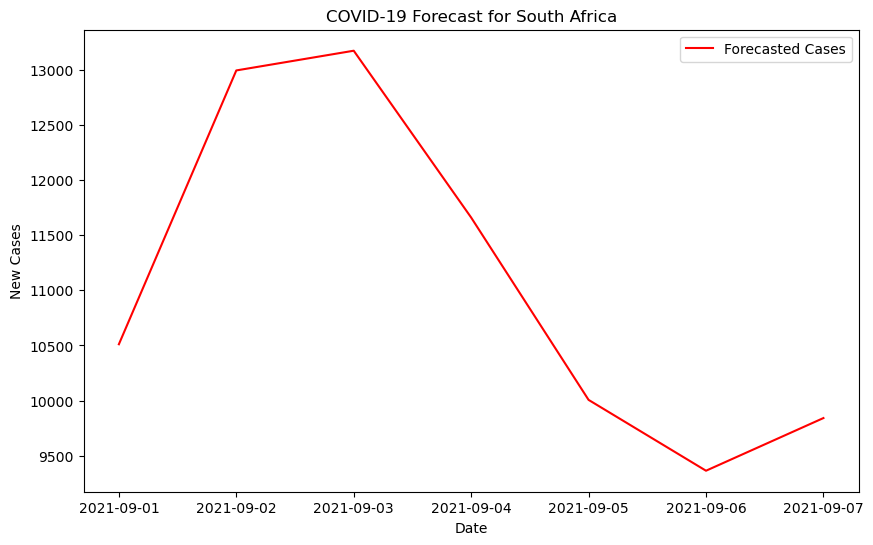

In [280]:
#Now everthing all together
if __name__ == "__main__":
    # Ingest data,this is the part which takes some time
    data = Ingestion()

    # Model data and make predictions
    pred = Modeling(data)

    # Report results
    SimpleReporting(pred)